# **Predict Health Insurance Owners' who will be interested in Vehicle Insurance**

An insurance company that has provided Health Insurance to its customers want to build a model to predict whether the policyholders (customers) from past year will also be interested in Vehicle Insurance provided by the company.

In [1]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek, SMOTEENN
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler,RobustScaler,StandardScaler
from sklearn.model_selection import train_test_split

# **Load the Data**

In [2]:
#Importing Data Set
train = pd.read_csv(r"C:\Users\user\Desktop\vehicle-insurance-classification\train.csv")
test = pd.read_csv(r"C:\Users\user\Desktop\vehicle-insurance-classification\test.csv")

# **View the data**

In [3]:
#View the data
train.head(10)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,508077,Male,39,1,28.0,0,1-2 Year,Yes,33670.0,124.0,133,1
1,116379,Male,60,1,9.0,1,1-2 Year,Yes,32660.0,26.0,64,0
2,24159,Female,20,1,43.0,0,< 1 Year,No,2630.0,160.0,283,0
3,129481,Female,22,1,47.0,0,< 1 Year,Yes,32665.0,26.0,42,0
4,469280,Male,25,1,28.0,1,< 1 Year,No,21602.0,152.0,293,0
5,219578,Female,34,1,28.0,0,1-2 Year,Yes,31853.0,157.0,34,1
6,298263,Female,20,1,35.0,1,< 1 Year,No,31962.0,160.0,257,0
7,388131,Female,41,1,36.0,0,> 2 Years,Yes,2630.0,124.0,103,1
8,46245,Female,26,1,29.0,1,< 1 Year,No,2630.0,160.0,68,0
9,345554,Female,42,1,28.0,1,1-2 Year,No,40643.0,13.0,176,0


In [4]:
display(f'Number of rows (clients): {train.shape[0]}')
display(f'Number of columns (characteristics): {train.shape[1]}')

'Number of rows (clients): 244578'

'Number of columns (characteristics): 12'

In [5]:
train.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,244578.000000,244578.000000,244578.000000,244578.000000,244578.000000,244578.000000,244578.000000,244578.000000,244578.000000
mean,234645.165109,38.516400,0.998091,26.407007,0.489713,30705.566331,111.942566,154.291228,0.163617
std,139466.538310,15.221267,0.043655,13.179890,0.499895,16994.006743,54.304292,83.667275,0.369928
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,115277.000000,25.000000,1.000000,15.000000,0.000000,24560.000000,26.000000,82.000000,0.000000
50%,230961.500000,36.000000,1.000000,28.000000,0.000000,31688.000000,147.000000,154.000000,0.000000
75%,345559.750000,49.000000,1.000000,35.000000,1.000000,39424.000000,152.000000,227.000000,0.000000
max,508144.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


# **Data Cleaning**

In [6]:
# drop id column
id = train['id']
train = train.drop('id',axis=1)
test = test.drop('id',axis=1)

In [7]:
# check missing values in train set
train.isnull().sum()

Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

no missing data
nothing to replace

In [8]:
# check for duplicated data in train set
train.duplicated().any()

True

no duplicated data
nothing to remove

# **Data exploration**

<AxesSubplot:>

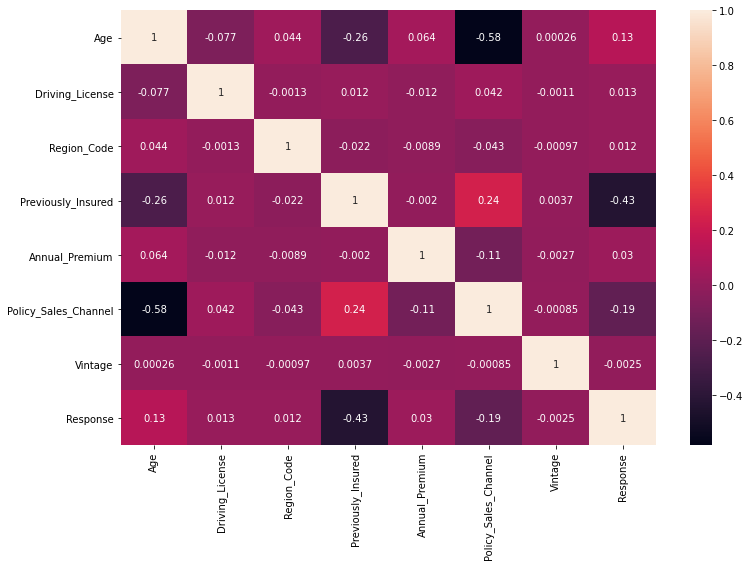

In [9]:
#Plotting a diagonal correlation matrix

correlation_matrix = train.corr()

plt.figure(figsize=(12,8))
sns.heatmap(correlation_matrix,annot=True)

In [10]:
hig_corr_features = correlation_matrix.index[abs(correlation_matrix["Response"]) >= 0.2]
hig_corr_features

Index(['Previously_Insured', 'Response'], dtype='object')

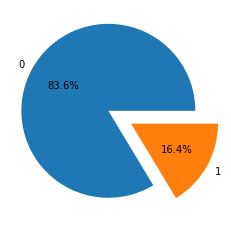

In [11]:
plt.pie(train['Response'].value_counts(),labels=train['Response'].value_counts().index,autopct="%0.1f%%",explode=[0.1,0.2],radius=1);

There is class imbalance in the target variable


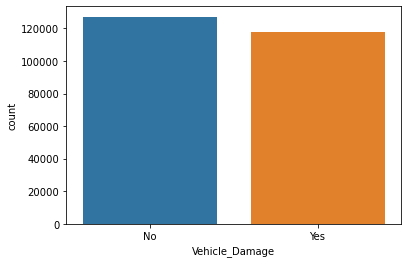

In [12]:
vehicle_Damage=train.groupby('Vehicle_Damage')['Response'].mean()
sns.countplot(x='Vehicle_Damage',data=train,order=vehicle_Damage.index);

People with previously damaged vehicels have much higher chances of buying insurance.

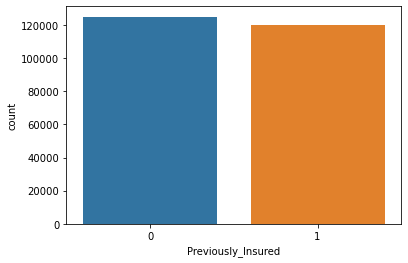

In [13]:
previously_Insured=train.groupby('Previously_Insured')['Response'].mean()
sns.countplot(x='Previously_Insured',data=train,order=previously_Insured.index);

The majority of respondents who shown interest in insurance,do not have their vehicles insured previously.

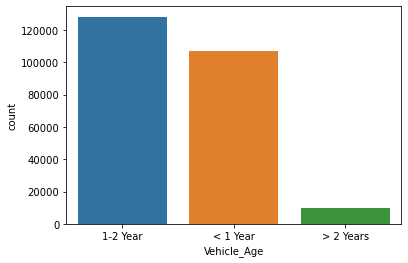

In [14]:
vehicle_Age=train.groupby('Vehicle_Age')['Response'].mean()
sns.countplot(x='Vehicle_Age',data=train ,order=vehicle_Age.index);

respondents with vehicule age of 0-2 show greater interest.

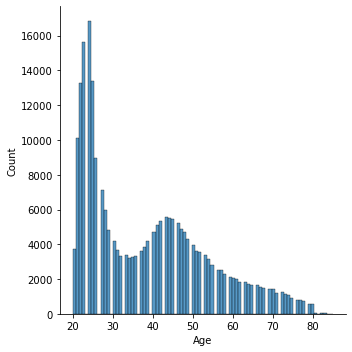

In [15]:
#Age Distribution of Customers
sns.displot(train.Age)

Age variable has non gaussian distribution

<AxesSubplot:xlabel='Vehicle_Age', ylabel='count'>

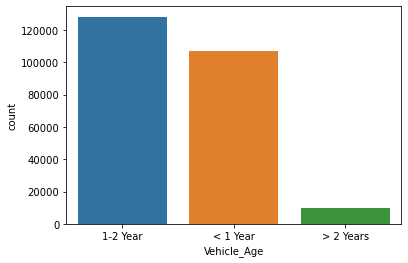

In [16]:
#Vehicle Age
sns.countplot(x=train.Vehicle_Age)

# **Data Preprocessing**

In [17]:
import numpy as np
Q1 = np.percentile(train['Annual_Premium'], 25, interpolation = 'midpoint')
Q3 = np.percentile(train['Annual_Premium'], 75, interpolation = 'midpoint')
IQR = Q3 - Q1

upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR
#replace outliers with the mean of 'EXPERIENCE_LENGTH' col
test['Annual_Premium'] = test['Annual_Premium'].where((test['Annual_Premium'] >= lower_bound) & (test['Annual_Premium'] <= upper_bound), np.log1p(test['Annual_Premium']))
train['Annual_Premium'] = train['Annual_Premium'].where((train['Annual_Premium'] >= lower_bound) & (train['Annual_Premium'] <= upper_bound), np.log1p(train['Annual_Premium']))

In [18]:
from sklearn.preprocessing import OneHotEncoder
# Initialize the OneHotEncoder object
onehot_enc = OneHotEncoder()

# Fit and transform the OneHotEncoder object on the categorical variables
onehot = onehot_enc.fit_transform(train[['Gender','Vehicle_Age','Vehicle_Damage']])

# Convert the one-hot encoded sparse matrix to a dense array and create a new dataframe
onehot_df = pd.DataFrame(onehot.toarray(), columns=onehot_enc.get_feature_names_out(input_features=['Gender','Vehicle_Age','Vehicle_Damage']))


# Print the one-hot encoded variables
train = pd.concat([train, onehot_df], axis=1)
train

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Gender_Female,Gender_Male,Vehicle_Age_1-2 Year,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_No,Vehicle_Damage_Yes
0,Male,39,1,28.0,0,1-2 Year,Yes,33670.0,124.0,133,1,0.0,1.0,1.0,0.0,0.0,0.0,1.0
1,Male,60,1,9.0,1,1-2 Year,Yes,32660.0,26.0,64,0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
2,Female,20,1,43.0,0,< 1 Year,No,2630.0,160.0,283,0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,Female,22,1,47.0,0,< 1 Year,Yes,32665.0,26.0,42,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,Male,25,1,28.0,1,< 1 Year,No,21602.0,152.0,293,0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244573,Male,24,1,28.0,0,1-2 Year,Yes,34733.0,122.0,99,0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
244574,Female,20,1,3.0,0,< 1 Year,Yes,33810.0,160.0,10,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
244575,Male,38,1,28.0,1,1-2 Year,No,33419.0,122.0,164,0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
244576,Female,33,1,28.0,1,1-2 Year,No,47285.0,124.0,166,0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


In [19]:
train = train.drop(['Gender','Vehicle_Age','Vehicle_Damage'],axis=1)

In [20]:
train.describe()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Gender_Female,Gender_Male,Vehicle_Age_1-2 Year,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_No,Vehicle_Damage_Yes
count,244578.000000,244578.000000,244578.000000,244578.000000,244578.000000,244578.000000,244578.000000,244578.000000,244578.000000,244578.000000,244578.000000,244578.000000,244578.000000,244578.000000,244578.000000
mean,38.516400,0.998091,26.407007,0.489713,28614.244737,111.942566,154.291228,0.163617,0.461979,0.538021,0.523600,0.435992,0.040408,0.519540,0.480460
std,15.221267,0.043655,13.179890,0.499895,15158.053777,54.304292,83.667275,0.369928,0.498553,0.498553,0.499444,0.495887,0.196915,0.499619,0.499619
min,20.000000,0.000000,0.000000,0.000000,11.030477,1.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,1.000000,15.000000,0.000000,23354.000000,26.000000,82.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,36.000000,1.000000,28.000000,0.000000,30971.000000,147.000000,154.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,49.000000,1.000000,35.000000,1.000000,38361.000000,152.000000,227.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,85.000000,1.000000,52.000000,1.000000,61718.000000,163.000000,299.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# **Data Modelling**


In [21]:
#Divide the data into “attributes” and “labels”
X = train.drop('Response',axis=1) #separate the other attributes from the predicting attribute
y = train['Response']

In [22]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,stratify=y, random_state=0) # 80% training and 20% test

In [23]:
X_train.shape,y_train.shape

((183433, 14), (183433,))

In [24]:
from sklearn.decomposition import PCA

n_components = 7 # for example
pca = PCA(n_components=n_components)

# fit PCA on training data
pca.fit(X_train)

# transform both training and test data
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

# create new column names
column_names = [f"PC{i+1}" for i in range(n_components)]

# convert transformed data to dataframes with new column names
X_train_pca_df = pd.DataFrame(X_train_pca, columns=column_names)
X_test_pca_df = pd.DataFrame(X_test_pca, columns=column_names)

In [25]:
X_train = X_train_pca_df
X_test = X_test_pca_df

In [26]:
X_train.shape,y_train.shape

((183433, 7), (183433,))

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, log_loss, f1_score
from sklearn.model_selection import learning_curve
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression


In [28]:
rfc = RandomForestClassifier(class_weight='balanced')
rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced')

In [29]:
# Print the classification report and confusion matrix
y_pred = rfc.predict(X_test)
print("Classification Report: \n", classification_report(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.93      0.90     51141
           1       0.50      0.34      0.40     10004

    accuracy                           0.84     61145
   macro avg       0.69      0.63      0.65     61145
weighted avg       0.82      0.84      0.82     61145

Confusion Matrix: 
 [[47706  3435]
 [ 6632  3372]]


<AxesSubplot:>

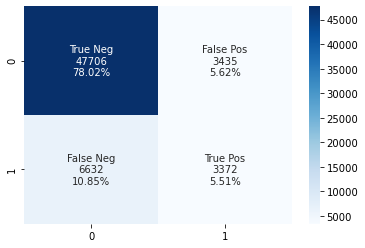

In [30]:
cf_matrixRF = confusion_matrix(y_test, y_pred)

group_names  = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrixRF.flatten()]

group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrixRF.flatten()/np.sum(cf_matrixRF)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrixRF, annot=labels, fmt='', cmap='Blues')

In [31]:
import scikitplot as skplt

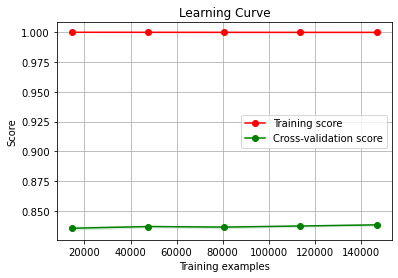

In [32]:
skplt.estimators.plot_learning_curve(rfc, X_train, y_train)
plt.show()

In [33]:
LR = LogisticRegression(class_weight='balanced')

# Fit the classifier to the training data
LR.fit(X_train, y_train)

# Use the classifier to predict the test data
y_pred = LR.predict(X_test)

# Display classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.62      0.76     51141
           1       0.33      0.99      0.50     10004

    accuracy                           0.68     61145
   macro avg       0.67      0.80      0.63     61145
weighted avg       0.89      0.68      0.72     61145

Confusion Matrix:
[[31486 19655]
 [  126  9878]]


C:\Users\user\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<AxesSubplot:>

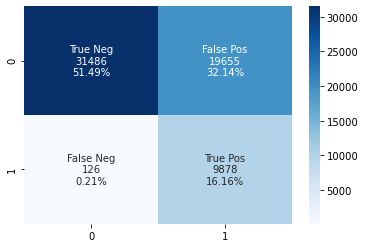

In [34]:
cf_matrixLR = confusion_matrix(y_test, y_pred)

group_names  = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrixLR.flatten()]

group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrixLR.flatten()/np.sum(cf_matrixLR)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrixLR, annot=labels, fmt='', cmap='Blues')

C:\Users\user\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\user\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

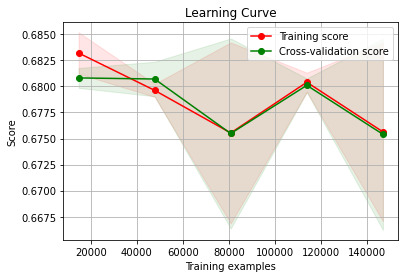

In [35]:
skplt.estimators.plot_learning_curve(LR, X_train, y_train)
plt.show()

In [36]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)

# Fit the classifier to the training data
dt.fit(X_train, y_train)

# Use the classifier to predict the test data
y_pred = dt.predict(X_test)

# Display classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     51141
           1       0.43      0.42      0.42     10004

    accuracy                           0.81     61145
   macro avg       0.66      0.65      0.66     61145
weighted avg       0.81      0.81      0.81     61145

Confusion Matrix:
[[45538  5603]
 [ 5814  4190]]


<AxesSubplot:>

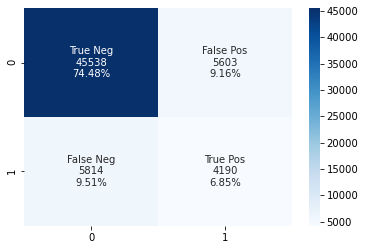

In [37]:
cf_matrixDT = confusion_matrix(y_test, y_pred)

group_names  = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrixDT.flatten()]

group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrixDT.flatten()/np.sum(cf_matrixDT)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrixDT, annot=labels, fmt='', cmap='Blues')

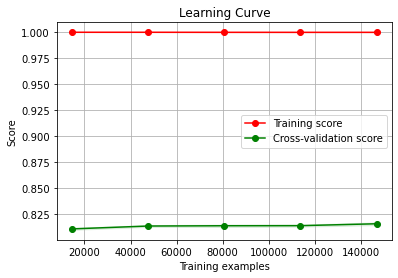

In [38]:
skplt.estimators.plot_learning_curve(dt, X_train, y_train)
plt.show()

In [39]:
from catboost import CatBoostClassifier, cv
cat = CatBoostClassifier(iterations = 1000, learning_rate = 0.1,
                         depth=6, loss_function="Logloss",silent=True)

# Fit the classifier to the training data
cat.fit(X_train, y_train)

# Use the classifier to predict the test data
y_pred = cat.predict(X_test)

# Display classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     51141
           1       0.52      0.36      0.43     10004

    accuracy                           0.84     61145
   macro avg       0.70      0.65      0.67     61145
weighted avg       0.82      0.84      0.83     61145

Confusion Matrix:
[[47833  3308]
 [ 6385  3619]]


<AxesSubplot:>

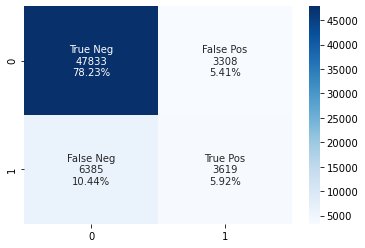

In [40]:
cf_matrixCB = confusion_matrix(y_test, y_pred)

group_names  = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrixCB.flatten()]

group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrixCB.flatten()/np.sum(cf_matrixCB)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrixCB, annot=labels, fmt='', cmap='Blues')

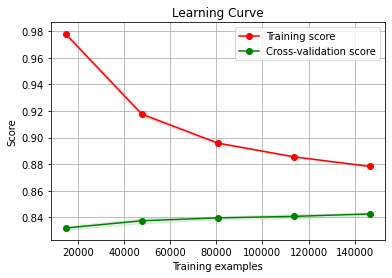

In [41]:
skplt.estimators.plot_learning_curve(cat, X_train, y_train)
plt.show()

In [42]:
import lightgbm as lgb
# Create a LightGBM classifier with class weight parameter
lgbm = lgb.LGBMClassifier(class_weight={0:.6, 1:.4}, random_state=42)

# Fit the classifier to the training data
lgbm.fit(X_train, y_train)

# Use the classifier to predict the test data
y_pred = lgbm.predict(X_test)

# Display classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91     51141
           1       0.47      0.01      0.02     10004

    accuracy                           0.84     61145
   macro avg       0.65      0.50      0.46     61145
weighted avg       0.78      0.84      0.76     61145

Confusion Matrix:
[[51038   103]
 [ 9913    91]]


<AxesSubplot:>

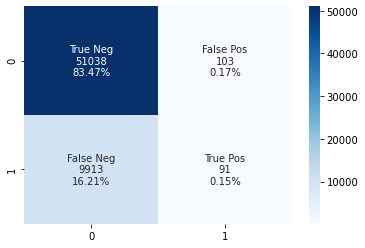

In [43]:
cf_matrixlgb = confusion_matrix(y_test, y_pred)

group_names  = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrixlgb.flatten()]

group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrixlgb.flatten()/np.sum(cf_matrixlgb)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrixlgb, annot=labels, fmt='', cmap='Blues')

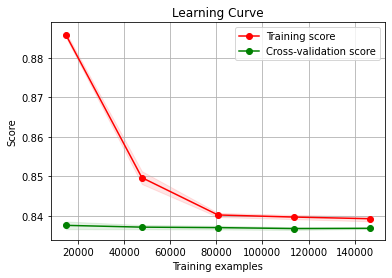

In [44]:
skplt.estimators.plot_learning_curve(lgbm, X_train, y_train)
plt.show()